# Multisession registration with CaImAn

This notebook will help to demonstrate how to use CaImAn on movies recorded in multiple sessions. CaImAn has in-built functions that align movies from two or more sessions and try to recognize components that are imaged in some or all of these recordings.

The basic function for this is `caiman.base.rois.register_ROIs()`. It takes two sets of spatial components and finds components present in both using an intersection over union metric and the Hungarian algorithm for optimal matching.
`caiman.base.rois.register_multisession()` takes a list of spatial components, aligns sessions 1 and 2, keeps the union of the matched and unmatched components to register it with session 3 and so on.

In [2]:
from IPython import get_ipython
from matplotlib import pyplot as plt
import numpy as np
import pickle
import h5py
import glob
import pims_nd2
import pandas as pd
from collections import OrderedDict
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from itertools import combinations
import scipy.stats as stats

from caiman.base.rois import register_multisession
from caiman.utils import visualization
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.utils.utils import download_demo

import sys
sys.path.append('..')
from placecode.cross_registration_functions import CellTrackingMultipleAnimals as celltrack


try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

loading the files and trying to make everything automatic
running multiple conditions per multiple animals

In [50]:
animals=['OPI2342','OPI2356']
conditions=['bl_d1','bl_d2','24h_post','novel_belt_d1','novel_belt_d2','novel_belt_d3']

Initializing the necessary files for cross registration

In [53]:
files_list=OrderedDict()
templates_list=OrderedDict()
cnmf_list=OrderedDict()
spatials=OrderedDict()
dims=OrderedDict()
assignments=OrderedDict()
cr_reg_cells=OrderedDict()
cr_reg_cells_df=OrderedDict()

for animal in animals:      

    # Load multisession data (spatial components and mean intensity templates) (should be replaced by actual data)
    home_folder=f'D:/sd_project_pbox/exported_data/{animal}/'
    raw_data_folder=f'D:/sd_project_pbox/raw_data/{animal}'
    output_folder=f'D:/sd_project_pbox/results/{animal}/'

    files_list[animal]=[]
    templates_list[animal]=[]
    cnmf_list[animal]=[]
    spatials[animal]=[]
    dims[animal]=[]
    assignments[animal]=[]
    cr_reg_cells[animal]=[]
    cr_reg_cells_df[animal]=[]
# spatials=[cnmf_1.estimates.A,cnmf_2.estimates.A,cnmf_3.estimates.A]
# dims=cnmf_1.dims

    for condition in conditions:

        #finding file paths
        fpath= glob.glob(f"{home_folder}/{animal}_{condition}/*.hdf5")[0]
        files_list[animal].append(fpath)

        #sstoring cnfs
        cnmf_ind=cnmf.load_CNMF(fpath,'r')
        cnmf_list[animal].append(cnmf_ind)
        #sotring spatial components
        spatial=cnmf_ind.estimates.A
        spatials[animal].append(spatial)
        #storing dims
        dim=cnmf_ind.dims
        dims[animal].append(dim)

        #template paths
        template_path=glob.glob(f"{raw_data_folder}/*{condition}/*.nd2")[0]
        nikon_movie=pims_nd2.ND2_Reader(template_path)
        template=np.mean(nikon_movie[:600],axis=0)
        templates_list[animal].append(template)


## Use `register_multisession()`

The function `register_multisession()` requires 3 arguments:
- `A`: A list of ndarrays or scipy.sparse.csc matrices with (# pixels X # component ROIs) for each session
- `dims`: Dimensions of the FOV, needed to restore spatial components to a 2D image
- `templates`: List of ndarray matrices of size `dims`, template image of each session

In [54]:
for animal in animals:
    spatial_union, assignments_per_animal, matchings = register_multisession(A=spatials[animal], dims=dims[animal][0])
    assignments[animal]=assignments_per_animal


c:\Users\ttami\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


FInd the rows where there are no NaN values. Meaning find cells that are cross registered across all conditions

In [6]:
# Find the rows where there are no NaN values
#meaning where are the cells in all of the days

for animal in animals:    
    cr_reg_cells[animal] = assignments[animal][~np.isnan(assignments[animal]).any(axis=1)].astype(int)
    cr_reg_cells_df[animal]=pd.DataFrame(data=cr_reg_cells[animal],columns=conditions)


indetifying and storing silent sells, place cells and non place so that I can study the transition after

In [55]:
#first store the place cells somewhere
pc_cells=OrderedDict()
non_pc_cells=OrderedDict()
silent_cells=OrderedDict()
number_of_units=OrderedDict()

for animal in animals:
    output_file=f"D:/sd_project_pbox/results/{animal}"


    for condition in conditions:
        pc_cells[f'{animal}_{condition}']=[]
        non_pc_cells[f'{animal}_{condition}']=[]
        silent_cells[f'{animal}_{condition}']=[]
        number_of_units[f'{animal}_{condition}']=[]
        

        #appending place cells
        pc_cells_per_day=h5py.File(f'{output_file}/{condition}/output_info.h5')['place_cells_tuned_vector']
        pc_cells_per_day=np.array(pc_cells_per_day)
        pc_cells[f'{animal}_{condition}'].append(pc_cells_per_day)

        #appending non place cells
        non_pc_cells_per_day=h5py.File(f'{output_file}/{condition}/output_info.h5')['non_place_cells_tuned_vector']
        non_pc_cells_per_day=np.array(non_pc_cells_per_day)
        non_pc_cells[f'{animal}_{condition}'].append(non_pc_cells_per_day)

        #appending silent cells
        silent_cells_per_day=h5py.File(f'{output_file}/{condition}/output_info.h5')['silent_cells']
        silent_cells_per_day=np.array(silent_cells_per_day)
        silent_cells[f'{animal}_{condition}'].append(silent_cells_per_day)

        #appending number of units
        #appending silent cells
        number_of_units_per_day=h5py.File(f'{output_file}/{condition}/output_info.h5')['number of units']
        number_of_units_per_day=np.array(number_of_units_per_day)
        number_of_units[f'{animal}_{condition}'].append(number_of_units_per_day)

# Create a new OrderedDict with only the number of units extracted
number_of_units = OrderedDict((key, int(value[0])) for key, value in number_of_units.items())


In [56]:
#evaluating percentage of place cells, silents cells and non place cells
pc_cells_prc=OrderedDict()
non_pc_cells_prc=OrderedDict()
silent_cells_prc=OrderedDict()

for condition in conditions:
    pc_cells_prc[condition]=[]
    non_pc_cells_prc[condition]=[]
    silent_cells_prc[condition]=[]
    for animal in animals:

        pc_cell_len=len(pc_cells[f'{animal}_{condition}'][0])
        pc_prc=100 * pc_cell_len/number_of_units[f'{animal}_{condition}']
        pc_cells_prc[condition].append(pc_prc)

        non_pc_cell_len=len(non_pc_cells[f'{animal}_{condition}'][0])
        non_pc_prc=100 * non_pc_cell_len/number_of_units[f'{animal}_{condition}']
        non_pc_cells_prc[condition].append(non_pc_prc)

        silent_cell_len=len(silent_cells[f'{animal}_{condition}'][0])
        silent_prc=100 * silent_cell_len/number_of_units[f'{animal}_{condition}']
        silent_cells_prc[condition].append(silent_prc)

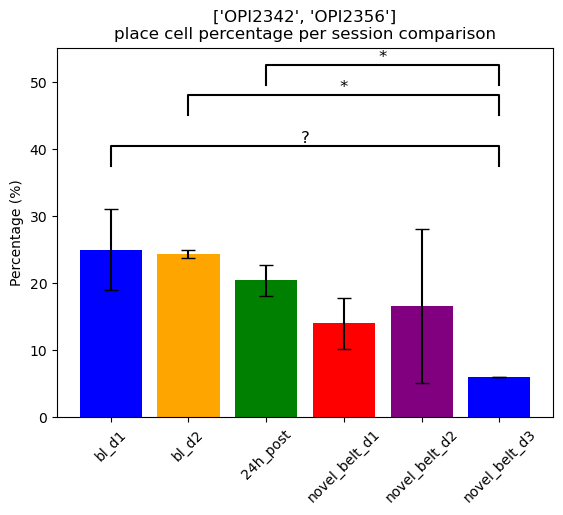

bl_d1 vs bl_d2 T-statistic: 0.91880, p-value: 0.92235
bl_d1 vs 24h_post T-statistic: 0.91880, p-value: 0.55243
bl_d1 vs novel_belt_d1 T-statistic: 0.91880, p-value: 0.26310
bl_d1 vs novel_belt_d2 T-statistic: 0.91880, p-value: 0.58430
bl_d1 vs novel_belt_d3 T-statistic: 0.91880, p-value: 0.08842
bl_d2 vs 24h_post T-statistic: 0.91880, p-value: 0.24612
bl_d2 vs novel_belt_d1 T-statistic: 0.91880, p-value: 0.11499
bl_d2 vs novel_belt_d2 T-statistic: 0.91880, p-value: 0.57135
bl_d2 vs novel_belt_d3 T-statistic: 0.91880, p-value: 0.00128
24h_post vs novel_belt_d1 T-statistic: 0.91880, p-value: 0.28551
24h_post vs novel_belt_d2 T-statistic: 0.91880, p-value: 0.77602
24h_post vs novel_belt_d3 T-statistic: 0.91880, p-value: 0.02510
novel_belt_d1 vs novel_belt_d2 T-statistic: 0.91880, p-value: 0.84977
novel_belt_d1 vs novel_belt_d3 T-statistic: 0.91880, p-value: 0.17012
novel_belt_d2 vs novel_belt_d3 T-statistic: 0.91880, p-value: 0.45519


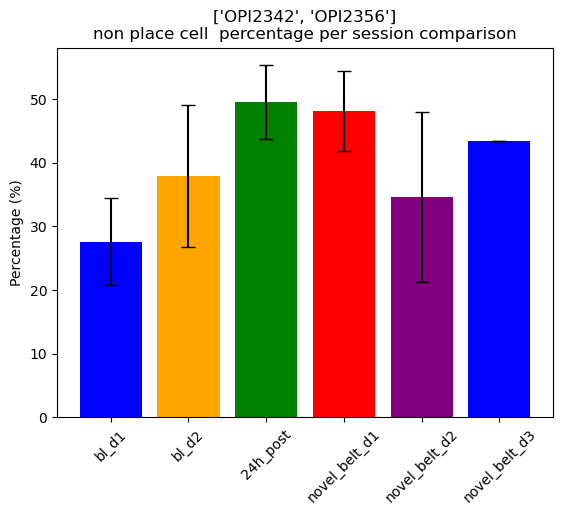

bl_d1 vs bl_d2 T-statistic: -0.65445, p-value: 0.51191
bl_d1 vs 24h_post T-statistic: -0.65445, p-value: 0.13545
bl_d1 vs novel_belt_d1 T-statistic: -0.65445, p-value: 0.15869
bl_d1 vs novel_belt_d2 T-statistic: -0.65445, p-value: 0.68517
bl_d1 vs novel_belt_d3 T-statistic: -0.65445, p-value: 0.14940
bl_d2 vs 24h_post T-statistic: -0.65445, p-value: 0.45600
bl_d2 vs novel_belt_d1 T-statistic: -0.65445, p-value: 0.51078
bl_d2 vs novel_belt_d2 T-statistic: -0.65445, p-value: 0.86506
bl_d2 vs novel_belt_d3 T-statistic: -0.65445, p-value: 0.67845
24h_post vs novel_belt_d1 T-statistic: -0.65445, p-value: 0.88792
24h_post vs novel_belt_d2 T-statistic: -0.65445, p-value: 0.41303
24h_post vs novel_belt_d3 T-statistic: -0.65445, p-value: 0.39929
novel_belt_d1 vs novel_belt_d2 T-statistic: -0.65445, p-value: 0.45550
novel_belt_d1 vs novel_belt_d3 T-statistic: -0.65445, p-value: 0.52545
novel_belt_d2 vs novel_belt_d3 T-statistic: -0.65445, p-value: 0.58002


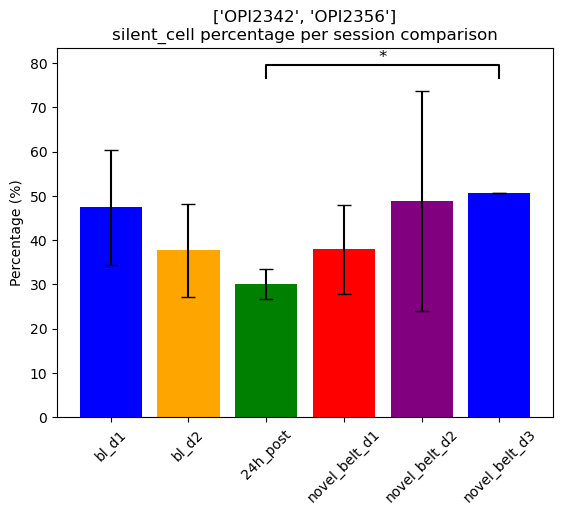

bl_d1 vs bl_d2 T-statistic: -0.07603, p-value: 0.61955
bl_d1 vs 24h_post T-statistic: -0.07603, p-value: 0.32556
bl_d1 vs novel_belt_d1 T-statistic: -0.07603, p-value: 0.62093
bl_d1 vs novel_belt_d2 T-statistic: -0.07603, p-value: 0.96476
bl_d1 vs novel_belt_d3 T-statistic: -0.07603, p-value: 0.82333
bl_d2 vs 24h_post T-statistic: -0.07603, p-value: 0.56256
bl_d2 vs novel_belt_d1 T-statistic: -0.07603, p-value: 0.99102
bl_d2 vs novel_belt_d2 T-statistic: -0.07603, p-value: 0.72066
bl_d2 vs novel_belt_d3 T-statistic: -0.07603, p-value: 0.34203
24h_post vs novel_belt_d1 T-statistic: -0.07603, p-value: 0.54151
24h_post vs novel_belt_d2 T-statistic: -0.07603, p-value: 0.53339
24h_post vs novel_belt_d3 T-statistic: -0.07603, p-value: 0.02749
novel_belt_d1 vs novel_belt_d2 T-statistic: -0.07603, p-value: 0.72351
novel_belt_d1 vs novel_belt_d3 T-statistic: -0.07603, p-value: 0.33297
novel_belt_d2 vs novel_belt_d3 T-statistic: -0.07603, p-value: 0.94631


In [63]:
data_list=[pc_cells_prc,non_pc_cells_prc,silent_cells_prc]
data_list_names=['place cell','non place cell ','silent_cell']

for data,data_id in zip(data_list,data_list_names):

    # Calculate mean and standard deviation for each condition

    means = {k: np.mean(v) for k, v in data.items()}
    stds = {k: np.std(v) for k, v in data.items()}

    # Plotting the bar plot with error bars
    fig, ax = plt.subplots()

    conditions_to_compare = list(data.keys())
    mean_values = [means[cond] for cond in conditions_to_compare]
    std_values = [stds[cond] for cond in conditions_to_compare]

    bars=ax.bar(conditions_to_compare, mean_values, yerr=std_values, capsize=5, color=['blue', 'orange', 'green', 'red', 'purple'])
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'{animals}\n{data_id} percentage per session comparison')

    # Perform pairwise t-tests
    p_values = {}
    for cond1, cond2 in combinations(conditions_to_compare, 2):
        t_stat, p_value = stats.ttest_ind(data[cond1], data[cond2])
        p_values[(cond1, cond2)] = p_value

    plt.xticks(rotation=45)

    # Display p-values on the plot
    # Adjust the position as needed
    y_offset = -0.3#min(mean_values)# + 0.5* max(std_values)
    # for (cond1, cond2), p_value in p_values.items():
    #     plt.figtext(0.5, y_offset, f'{cond1} vs {cond2} p-value: {p_value:.5f}', ha='center', fontsize=10)
    #     y_offset -= 0.05


    # Display p-values on the plot and annotate significance
    starting_y = max(mean_values) + max(std_values) + 1  # Start lines above the tallest bar with some margin
    line_height = 3  # Height of each line
    asterisk_y_offset = 1.5 * line_height  # Vertical space increment for asterisks
    question_y_offset = 2.5 * line_height  # Vertical space increment for question marks

    for (cond1, cond2), p_value in p_values.items():
        if p_value < 0.05:
            symbol = '*'
            y_offset = asterisk_y_offset
        elif 0.1> p_value >= 0.05:
            symbol = '?'
            y_offset = question_y_offset
        else:
            continue  # No symbol or line for p-values >0.01

        idx1, idx2 = conditions_to_compare.index(cond1), conditions_to_compare.index(cond2)
        x1, x2 = bars[idx1].get_x() + bars[idx1].get_width() / 2, bars[idx2].get_x() + bars[idx2].get_width() / 2
        y = starting_y
        h = line_height
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
        ax.text((x1 + x2) / 2, y + h, symbol, ha='center', va='bottom', color='black', fontsize=12)
        starting_y += y_offset  # Increment y for the next line to avoid overlap

    save_folder=f'{output_folder}/cross_registration'
    plt.savefig(f'{save_folder}/{data_id}_percentage_comparison', format='png', dpi=300, bbox_inches='tight')
    plt.show()


    # Print the p-values for all comparisons
    for (cond1, cond2), p_value in p_values.items():
        print(f'{cond1} vs {cond2} T-statistic: {t_stat:.5f}, p-value: {p_value:.5f}')

compare place cells etc per days

In [ ]:
# Extracting numbers from arrays
extracted_data = OrderedDict()
for key, value in pc_cells.items():
    extracted_data[key] = value[0]

# Averaging the data by condition
averages = OrderedDict()
for key, values in extracted_data.items():
    condition = key.split('_')[-1]
    if condition not in averages:
        averages[condition] = []
    averages[condition].append(np.mean(values))

# Compute the mean for each condition
averages = {k: np.mean(v) for k, v in averages.items()}

# Perform t-tests between conditions
conditions = list(averages.keys())
for i in range(len(conditions)):
    for j in range(i + 1, len(conditions)):
        cond1 = conditions[i]
        cond2 = conditions[j]
        t_stat, p_value = ttest_ind(extracted_data[f'OPI2342_{cond1}'], extracted_data[f'OPI2342_{cond2}'])
        print(f'T-test between {cond1} and {cond2}: t-statistic = {t_stat}, p-value = {p_value}')



In [25]:
means

{'OPI2342_bl_d1': 73.3913043478261,
 'OPI2342_bl_d2': 49.148148148148145,
 'OPI2342_24h_post': 43.1764705882353,
 'OPI2356_bl_d1': 139.11111111111111,
 'OPI2356_bl_d2': 143.3,
 'OPI2356_24h_post': 129.984126984127}

In [ ]:
# Calculate mean and standard deviation for each condition
data=angle_between_sessions

means = {k: np.mean(v) for k, v in data.items()}
stds = {k: np.std(v) for k, v in data.items()}

# Plotting the bar plot with error bars
fig, ax = plt.subplots()

conditions_to_compare = list(data.keys())
mean_values = [means[cond] for cond in conditions_to_compare]
std_values = [stds[cond] for cond in conditions_to_compare]

bars=ax.bar(conditions_to_compare, mean_values, yerr=std_values, capsize=5, color=['blue', 'orange', 'green', 'red', 'purple'])
ax.set_ylabel('Angle drift')
ax.set_title(f'{animal}\nAverage drift between sessions')

# Perform pairwise t-tests
p_values = {}
for cond1, cond2 in combinations(conditions_to_compare, 2):
    t_stat, p_value = stats.ttest_ind(data[cond1], data[cond2])
    p_values[(cond1, cond2)] = p_value

plt.xticks(rotation=45)

# Display p-values on the plot
# Adjust the position as needed
y_offset = -0.3#min(mean_values)# + 0.5* max(std_values)
for (cond1, cond2), p_value in p_values.items():
    plt.figtext(0.5, y_offset, f'{cond1} vs {cond2} p-value: {p_value:.5f}', ha='center', fontsize=10)
    y_offset -= 0.05


# Display p-values on the plot and annotate significance
starting_y = max(mean_values) + max(std_values) + 1  # Start lines above the tallest bar with some margin
line_height = 10  # Height of each line
asterisk_y_offset = 1.5 * line_height  # Vertical space increment for asterisks
question_y_offset = 2.5 * line_height  # Vertical space increment for question marks

for (cond1, cond2), p_value in p_values.items():
    if p_value < 0.05:
        symbol = '*'
        y_offset = asterisk_y_offset
    elif 0.1> p_value >= 0.05:
        symbol = '?'
        y_offset = question_y_offset
    else:
        continue  # No symbol or line for p-values >0.01

    idx1, idx2 = conditions_to_compare.index(cond1), conditions_to_compare.index(cond2)
    x1, x2 = bars[idx1].get_x() + bars[idx1].get_width() / 2, bars[idx2].get_x() + bars[idx2].get_width() / 2
    y = starting_y
    h = line_height
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
    ax.text((x1 + x2) / 2, y + h, symbol, ha='center', va='bottom', color='black', fontsize=12)
    starting_y += y_offset  # Increment y for the next line to avoid overlap

save_folder=f'{output_folder}/cross_registration'
plt.savefig(f'{save_folder}/{animal}_drift_conditions.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


# Print the p-values for all comparisons
for (cond1, cond2), p_value in p_values.items():
    print(f'{cond1} vs {cond2} T-statistic: {t_stat:.5f}, p-value: {p_value:.5f}')

Making the sankey diagram for all mice and all conditions. this shows how cells alternate roles in all three conditions

In [ ]:
labels = [] 
colors = []
for condition in conditions:
  labels.extend([f"PC {condition}", f"nPC {condition}", f"sil {condition}"])  # for each condition, check categories PC, not-PC and low activity
  colors.extend(["red", "blue", "grey"])  # 255, 0, 0;  0, 255, 0; 0, 0, 0
# in each condition, we have PC and nPC categories, each have PC and nPC targets in the next category
sources = []  # should be 0, 1, 2, 0, 1, 2, 0, 1, 2, 3, 4, 5, 3, 4, 5, 3, 4, 5, ...
targets = []  # should be 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, ...
values = []
link_colors = []
#initlaiizng zero for all the values so that I can add numbers for individual animals
#I have to make ordered dictionary again. I will name them based on the source condition
n_PC_to_PC=OrderedDict()
n_non_PC_to_PC=OrderedDict()
n_sil_to_PC=OrderedDict()
n_PC_to_non_PC=OrderedDict()
n_sil_to_non_PC=OrderedDict()
n_non_PC_to_non_PC=OrderedDict()
n_PC_to_sil=OrderedDict()
n_non_PC_to_sil=OrderedDict()
n_sil_to_sil=OrderedDict()

for condition in conditions[:-1]:
  n_PC_to_PC[condition]=0
  n_non_PC_to_PC[condition]=0
  n_sil_to_PC[condition]=0
  n_PC_to_non_PC[condition]=0
  n_sil_to_non_PC[condition]=0
  n_non_PC_to_non_PC[condition]=0
  n_PC_to_sil[condition]=0
  n_non_PC_to_sil[condition]=0
  n_sil_to_sil[condition]=0


for animal in animals:

  df=cr_reg_cells_df[animal]
  for i_condition,condition in enumerate(conditions[:-1]):

    #target cells place cells
    n_PC_to_PC[condition]+=len(celltrack.cell_movement(df,animal,conditions[i_condition],conditions[i_condition+1],source_type=pc_cells,target_type=pc_cells))
    n_non_PC_to_PC[condition]+=len(celltrack.cell_movement(df,animal,conditions[i_condition],conditions[i_condition+1],source_type=non_pc_cells,target_type=pc_cells))
    n_sil_to_PC[condition]+=len(celltrack.cell_movement(df,animal,conditions[i_condition],conditions[i_condition+1],source_type=silent_cells,target_type=pc_cells))
    if animal ==animals[-1]:    
      sources.extend([3*i_condition,3*i_condition+1, 3*i_condition+2])
      targets.extend([3*(i_condition+1), 3*(i_condition+1), 3*(i_condition+1)])
      values.extend([n_PC_to_PC[condition], n_non_PC_to_PC[condition], n_sil_to_PC[condition]])
      link_colors.extend(["rgba(255, 0, 0, 0.4)", "rgba(0, 0, 255, 0.4)", "rgba(0, 0, 0, 0.4)"])  # PC -> x is light blue, nPC -> x is light red, Q -> y is "light black"

    #target cells non place cells
    n_PC_to_non_PC[condition]+=len(celltrack.cell_movement(df,animal,conditions[i_condition],conditions[i_condition+1],source_type=pc_cells,target_type=non_pc_cells))
    n_sil_to_non_PC[condition]+=len(celltrack.cell_movement(df,animal,conditions[i_condition],conditions[i_condition+1],source_type=silent_cells,target_type=non_pc_cells))
    n_non_PC_to_non_PC[condition]+=len(celltrack.cell_movement(df,animal,conditions[i_condition],conditions[i_condition+1],source_type=non_pc_cells,target_type=non_pc_cells))
    if animal ==animals[-1]:  
      sources.extend([3*i_condition,3*i_condition+1, 3*i_condition+2])
      targets.extend([3*(i_condition+1)+1, 3*(i_condition+1)+1, 3*(i_condition+1)+1])
      values.extend([n_PC_to_non_PC[condition], n_non_PC_to_non_PC[condition], n_sil_to_non_PC[condition]])
      link_colors.extend(["rgba(255, 0, 0, 0.4)", "rgba(0, 0, 255, 0.4)", "rgba(0, 0, 0, 0.4)"])  # PC -> x is light blue, nPC -> x is light red, Q -> y is "light black"

    #targer cell silent cells  
    n_PC_to_sil[condition]+=len(celltrack.cell_movement(df,animal,conditions[i_condition],conditions[i_condition+1],source_type=pc_cells,target_type=silent_cells))
    n_non_PC_to_sil[condition]+=len(celltrack.cell_movement(df,animal,conditions[i_condition],conditions[i_condition+1],source_type=non_pc_cells,target_type=silent_cells))
    n_sil_to_sil[condition]+=len(celltrack.cell_movement(df,animal,conditions[i_condition],conditions[i_condition+1],source_type=silent_cells,target_type=silent_cells))
    if animal ==animals[-1]:  
      sources.extend([3*i_condition,3*i_condition+1, 3*i_condition+2])
      targets.extend([3*(i_condition+1)+2, 3*(i_condition+1)+2, 3*(i_condition+1)+2])
      values.extend([n_PC_to_sil[condition], n_non_PC_to_sil[condition], n_sil_to_sil[condition]])
      link_colors.extend(["rgba(255, 0, 0, 0.4)", "rgba(0, 0, 255, 0.4)", "rgba(0, 0, 0, 0.4)"])  # PC -> x is light blue, nPC -> x is light red, Q -> y is "light black"
  
fig = go.Figure(data=[go.Sankey(
  node = dict(
    pad = 15,
    thickness = 20,
    line = dict(color = "black", width = 0.5),
    label = labels,
    color = colors
  ),
  link = dict(
    source = sources, # indices correspond to labels, eg A1, A2, A1, B1, ...
    target = targets,
    value = values,
    color = link_colors
))])

fig.update_layout(title_text=f'Multianimal session tracking\n{animals}\n\n{conditions}', font_size=10)
fig.write_html(f'D:/sd_project_pbox/results/multiple_animals/cross_registration/{animals}_{conditions}.html')

#pio.write_image(fig, F'{output_folder}/{animal}_sankey_diagram.pdf')



In [ ]:

sessions=conditions #all of them
sessions=['baseline_d1','baseline_d2']
sessions=['baseline_d2','24hrs_post_SD']
#sessions=conditions

# Example usage for two sessions:
filtered_df = filter_cross_registered_place_cells(df, sessions, pc_cells)


In [ ]:
#indetify only the cross registered place cells in each of the recordings
fr_rate_maps_to_compare=OrderedDict()

for session in sessions:
    fr_rate_maps_to_compare[session]=[]

for session in sessions:
    avr_fr_rate_map=h5py.File(f'{output_folder}/{session}/output_info.h5')['avr_firing_rate_maps']
    avr_fr_rate_map=pd.DataFrame(avr_fr_rate_map)
    cr_reg_cells_values=filtered_df[session].values
    avr_fr_rate_map=avr_fr_rate_map.iloc[cr_reg_cells_values]
    fr_rate_maps_to_compare[session]=avr_fr_rate_map



In [ ]:
#plotting the original place cell coding diagrams

sel_fontize=20

fig,ax=plt.subplots(2,len(sessions),figsize=(20,20))
fig.suptitle(f'{animal}\ncross registered place cells\n comparison{sessions}\n Up Original sorting\nBelow sorted to {sessions[0]}',fontsize=sel_fontize+5)
                    
custom_ticks = [0, 50, 100, 150]  # Specify the positions where you want the ticks
custom_labels = ['0', '50', '100', '150']  

for i,session in enumerate(sessions):
    place_cell_activity=fr_rate_maps_to_compare[session]
    place_cell_indexes_max=np.argmax(place_cell_activity,axis=1) #finding the place of the max activity of every cell
    place_cell_indexed_filtered=place_cell_activity.apply(np.argmax, axis=1).sort_values().index #there are the new indexes of the place cells just so thez can form the nice place cell diagram
    transpose=place_cell_indexed_filtered
    place_cell_activity=place_cell_activity.reindex(index=transpose) #reindexing the place cell panda frame according to the max activitz and the position in the belt


    sns.heatmap(place_cell_activity,ax=ax[0,i],cmap='viridis',cbar=False)#,vmax=4)
    if i==0:
        ax[0,i].set_ylabel('cross registered place cells',fontsize=sel_fontize)
    else:
        ax[0,i].set_ylabel('')
    ax[0,i].set_xlabel('')
    ax[0,i].set_yticks([])
    ax[0,i].set_yticklabels([])
    ax[0,i].set_title(session,fontsize=sel_fontize)
    ax[0,i].set_xticks([])
    ax[0,i].set_xticklabels([])

#plotting place coding diagram transposed on the first one

place_cell_activity=fr_rate_maps_to_compare[sessions[0]].reset_index(drop=True)
place_cell_indexes_max=np.argmax(place_cell_activity,axis=1) #finding the place of the max activity of every cell
place_cell_indexed_filtered=place_cell_activity.apply(np.argmax, axis=1).sort_values().index 
transpose=place_cell_indexed_filtered

for i,session in enumerate(sessions):
    place_cell_activity=fr_rate_maps_to_compare[session].reset_index(drop=True)
    place_cell_activity=place_cell_activity.reindex(index=transpose) #reindexing the place cell panda frame according to the max activitz and the position in the belt

    sns.heatmap(place_cell_activity,ax=ax[1,i],cmap='viridis',cbar=False)
    if i==0:
        ax[1,i].set_ylabel('cross registered place cells',fontsize=sel_fontize)
    else:
        ax[1,i].set_ylabel('')
    ax[1,i].set_xlabel('Belt(cm)',fontsize=sel_fontize)
    ax[1,i].set_yticks([])
    ax[1,i].set_yticklabels([])
    ax[1,i].set_xticks(custom_ticks)
    ax[1,i].set_xticklabels(custom_labels,fontsize=sel_fontize)

plt.tight_layout()

plt.savefig(f'{output_folder}/cross_registration/{animal}_{sessions}_place_cells_comparison.png', format='png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_folder}/cross_registration/{animal}_{sessions}_place_cells_comparison.pdf', format='pdf', dpi=300, bbox_inches='tight')